In [29]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from model import UNET
from torch.utils.data import Dataset, DataLoader
import json
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image

In [30]:
# --- Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_PATH = "trained_model/my_checkpoint.pth.tar"


In [31]:
# %%
class LaneDataset(Dataset):
    """Custom Dataset for loading lane detection images and masks."""
    def __init__(self, annotations, transform=None):
        self.annotations = annotations
        self.transform = transform if transform is not None else transforms.Compose([
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = self.annotations[idx]['image']
        mask_path = self.annotations[idx]['mask']
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        image = self.transform(image)
        mask = self.transform(mask)

        # Ensure mask is a binary tensor with values 0 or 1
        mask = torch.where(mask > 0, 1.0, 0.0)
        return image, mask

In [32]:
# --- Data Loading ---
ANNOTATION_FILE = "processed/annotations.json"
with open(ANNOTATION_FILE, "r") as f:
    all_annotations = json.load(f)

train_ann, val_ann = train_test_split(all_annotations, test_size=0.2, random_state=42)

train_dataset = LaneDataset(annotations=train_ann)
val_dataset = LaneDataset(annotations=val_ann)

train_loader = DataLoader(
    train_dataset, batch_size=8, num_workers=0, pin_memory=True, shuffle=True
)
val_loader = DataLoader(
    val_dataset, batch_size=8, num_workers=0, pin_memory=True, shuffle=False
)

In [33]:
# --- Load Data (We only need the validation loader) ---
# Note: Ensure train_ann and val_ann are defined from a previous cell
# or re-run the data loading and splitting logic.
val_dataset = LaneDataset(annotations=val_ann)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True) # Shuffle to see different images each time


In [34]:
# --- Load the Trained Model ---
# 1. Re-create the model architecture
model = UNET(in_channels=3, out_channels=1).to(DEVICE)

In [35]:
# 2. Load the checkpoint
print("=> Loading checkpoint...")
checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)

# 3. Load the weights into the model
model.load_state_dict(checkpoint["state_dict"])
print("✅ Model loaded successfully!")

=> Loading checkpoint...


✅ Model loaded successfully!


In [36]:
# --- Run Visualization ---
def visualize_predictions(loader, model, device="cpu"):
    """
    Visualizes model predictions on a batch of data.
    """
    model.eval() # Set the model to evaluation mode
    
    # Get one batch from the loader
    images, masks = next(iter(loader))
    images = images.to(device)
    
    with torch.no_grad():
        # Get model predictions
        preds = torch.sigmoid(model(images))
        # Apply a threshold to get a binary mask
        preds = (preds > 0.5).float()

    # Move tensors to CPU for plotting with numpy/matplotlib
    images = images.cpu()
    masks = masks.cpu()
    preds = preds.cpu()

    # Plot the results
    plt.figure(figsize=(12, 12))
    plt.suptitle("Model Prediction vs. Ground Truth", fontsize=16)
    
    for i in range(images.shape[0]):
        # Original Image
        plt.subplot(4, 3, i*3 + 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title("Original Image")
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(4, 3, i*3 + 2)
        plt.imshow(masks[i].squeeze(), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(4, 3, i*3 + 3)
        plt.imshow(preds[i].squeeze(), cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


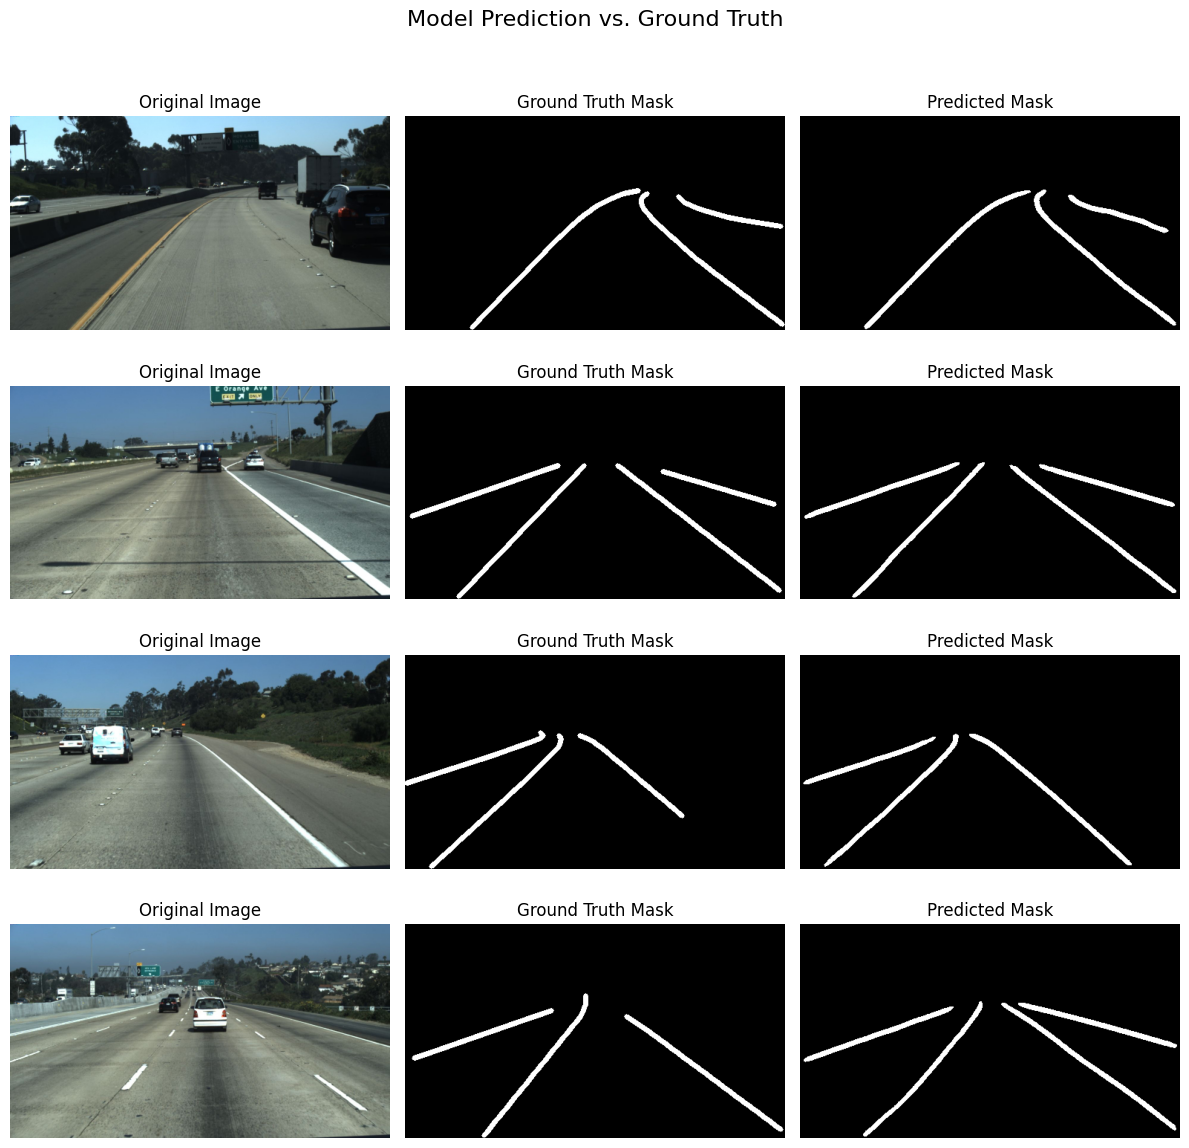

In [37]:
# Run the function
visualize_predictions(val_loader, model, device=DEVICE)